# TP OpenMP - October 2022

Florian Rascoussier

Bastien Barbe

Ce Notebook constitue une étude comparative des méthodes de parallélisation Open MP sur CPU pour différentes applications.

## Part 4 : Matrix multiplication and floating point precision

Ce programme multiplie des matrices en utilisant des flottants. 

### Compilation

In [22]:
# script params
EXEC: bool = True

In [23]:
# create /bin if it does not exist
!mkdir -p bin

# compile the programs
print("Compilation process:")
print("    + synchronous")
!g++ -o bin/tp_openmp_part_4_matrix_mul tp_openmp_part_4_matrix_mul.cpp utils.hpp -fopenmp -O3 -march=native -Wall

print("    + omp double")
!g++ -o bin/tp_openmp_part_4_matrix_mul_omp tp_openmp_part_4_matrix_mul_omp.cpp utils.hpp -fopenmp -O3 -march=native -Wall

print("    + omp float")
!g++ -o bin/tp_openmp_part_4_matrix_mul_omp_float tp_openmp_part_4_matrix_mul_omp_float.cpp utils.hpp -fopenmp -O3 -march=native -Wall

print("    + omp half")
!g++ -o bin/tp_openmp_part_4_matrix_mul_omp_half tp_openmp_part_4_matrix_mul_omp_half.cpp utils.hpp half.hpp -fopenmp -O3 -march=native -Wall

Compilation process:
    + synchronous
    + omp double
    + omp float
    + omp half


### Performance evaluation

In [24]:
# global vars
csv_result_file = "stats.csv"
csv_headers = {
    'version': str,
    'N': int,
    'M': int,
    'P': int,
    'runtime' : float
}

matrix_params: list[dict[str, int]] = [
    {"N": 500, "M": 500, "P": 500},
    {"N": 1000, "M": 1000, "P": 1000},
    {"N": 1500, "M": 1500, "P": 1500},
    {"N": 2000, "M": 2000, "P": 2000},
    {"N": 2500, "M": 2500, "P": 2500},
]

color_class = {
    "sequential": "red",
    "omp_double": "green",
    "omp_float": "blue",
    "omp_half": "orange"
}

repeats = 10

In [25]:
import os
import subprocess

try:
    os.remove(csv_result_file)
except OSError:
    pass

# create csv file
f = open(csv_result_file, "w")
f.write(",".join(csv_headers.keys()) + "\n")
f.close()

# execute the programs
def run_program(program_filepath: str, index: int):
    args = (program_filepath, 
        "-N", str(matrix_params[i]["N"]), 
        "-M", str(matrix_params[i]["M"]),
        "-P", str(matrix_params[i]["P"])
    )
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()
for _ in range(repeats):
    for i in range(0,len(matrix_params)):
        run_program("bin/tp_openmp_part_4_matrix_mul", i)
        run_program("bin/tp_openmp_part_4_matrix_mul_omp", i)
        run_program("bin/tp_openmp_part_4_matrix_mul_omp_float", i)
        run_program("bin/tp_openmp_part_4_matrix_mul_omp_half", i)

### Performance analysis

,version,N,M,P,runtime
0,sequential,500,500,500,0.087488
1,omp_double,500,500,500,0.057757
2,omp_float,500,500,500,0.042502
3,omp_half,500,500,500,0.172255
4,sequential,1000,1000,1000,0.727957
5,omp_double,1000,1000,1000,0.217875
6,omp_float,1000,1000,1000,0.203150
7,omp_half,1000,1000,1000,1.329212
8,sequential,1500,1500,1500,4.917360
9,omp_double,1500,1500,1500,1.121696


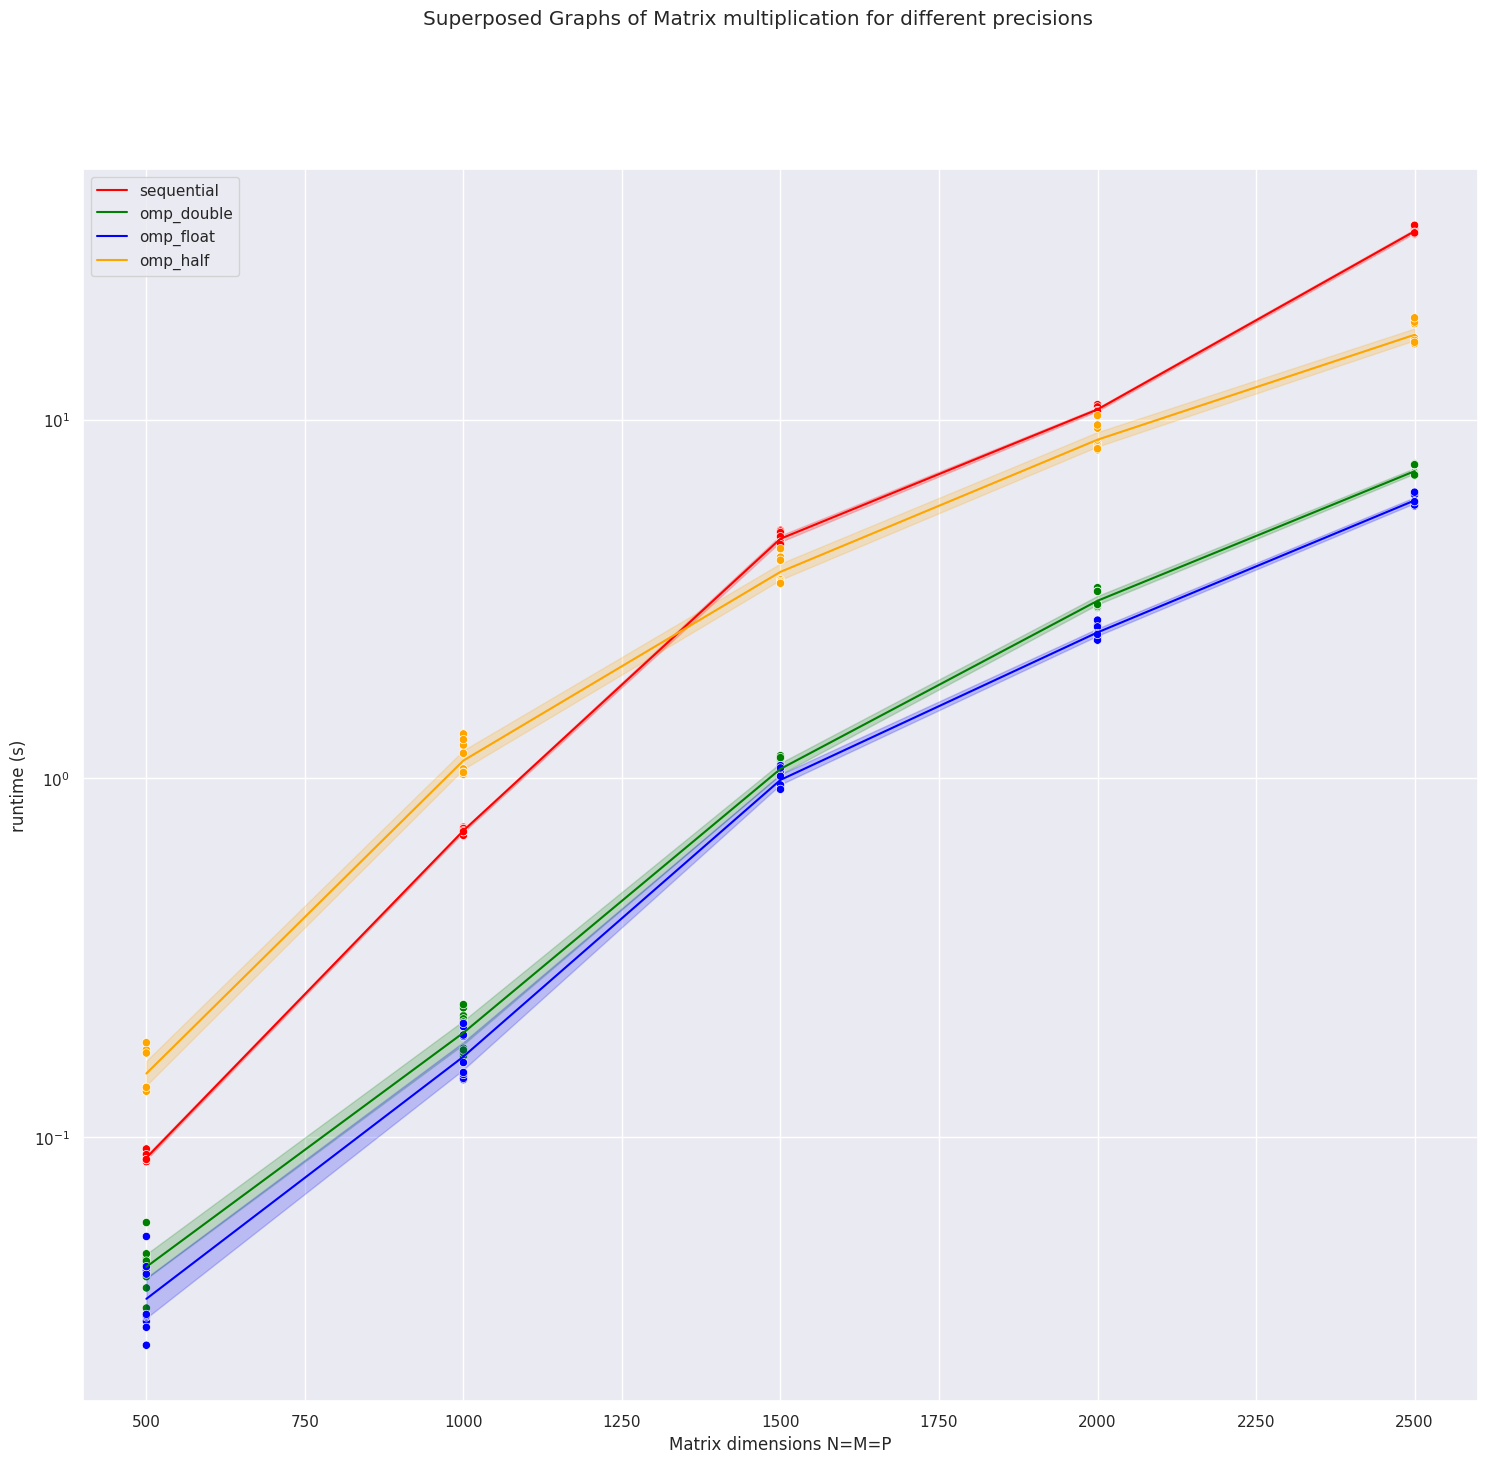

In [28]:
# superposed big graph
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from numpy import genfromtxt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()


df = pd.read_csv(
    csv_result_file,
    header=0, # line number of header
    dtype=csv_headers
)
display(df.head(10))

# filter out 0 runtime values
df = df[df.runtime > 0]

# display graphs
fig, ax = plt.subplots(figsize=(18,16))
fig.suptitle("Superposed Graphs of Matrix multiplication for different precisions")

for i in range(0, len(color_class.keys())):
    # print version graph data
    graph_version = list(color_class.keys())[i]
    df_plot_0 = df[df['version'] == graph_version]

    g0 = sns.lineplot(
        ax=ax,
        data=df_plot_0, 
        x="N",
        y="runtime", 
        hue="version",
        palette=color_class,
        style="version",
    )
    g0.set(yscale="log")
    g0.set(xlabel="Matrix dimensions N=M=P", ylabel="runtime (s)")
    g00 = sns.scatterplot(
        ax=ax,
        data=df_plot_0, 
        x="N",
        y="runtime", 
        hue="version",
        palette=color_class,
        legend=False,
    )
    g00.set(yscale="log")

plt.legend()
plt.show()

### Discussion

Dans toutes les situations observées, on observe que *float* est la plus rapide, suivi de près par *double*. Le résultat intéressant ici est de constater que la version utilisant les *half* n'apporte pas de gain de performance. On peut imaginer que cela est dû au fait que c'est un type spécial qui n'a pas d'instruction silicone.